In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.decomposition import PCA
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np 
import matplotlib.pyplot as plt

In [21]:

torch.manual_seed(42)
np.random.seed(42)

In [ ]:
# Function to compute the total number of trainable parameters in the model
def countTrainableParams(neural_net):
    total_params = 0
    for param in neural_net.parameters():
        if param.requires_grad:  # Only count parameters that require gradient computation
            total_params += param.numel()
    return total_params

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
import numpy as np  

# Define the neural network model
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.layer1 = nn.Linear(784, 128)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = self.layer3(x)
        return x

# Instantiate the model, loss function, and optimizer
neural_network = NeuralNet()
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(neural_network.parameters(), lr=0.003)

# Define transformations and load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load training and testing data
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)

# Create DataLoader for training and testing
trainloader = DataLoader(train_data, batch_size=64, shuffle=True)
testloader = DataLoader(test_data, batch_size=64, shuffle=False)

# Weights and losses collection
num_iterations = 8
num_epochs = 30
step_epoch = num_epochs // 3
layer2_weights_list = []
model_weights_list = []
losses_list = []

# Training loop for 8 iterations
for iteration in range(num_iterations):
    neural_network = NeuralNet()  # Reinitialize the model for each iteration
    optimizer = torch.optim.Adam(neural_network.parameters(), lr=0.003)
    
    layer2_weights_iteration = []
    model_weights_iteration = []
    iteration_losses = []

    for ep in range(num_epochs):
        running_loss = 0

        # Training loop
        for inputs, targets in trainloader:
            optimizer.zero_grad()                  
            outputs = neural_network(inputs)        
            loss = loss_function(outputs, targets)  
            loss.backward()                         
            optimizer.step()                        
            running_loss += loss.item()             

        # Every 3rd epoch, collect weights and loss
        if (ep + 1) % 3 == 0:
            layer2_weights = torch.flatten(neural_network.layer2.weight).detach().numpy()
            layer2_weights_iteration.append(layer2_weights)

            layer1_weights = torch.flatten(neural_network.layer1.weight).detach().numpy()
            layer3_weights = torch.flatten(neural_network.layer3.weight).detach().numpy()
            all_model_weights = np.concatenate((layer1_weights, layer2_weights, layer3_weights))
            model_weights_iteration.append(all_model_weights)

            average_loss = running_loss / len(trainloader)
            iteration_losses.append(average_loss)

    # Store the collected weights and losses for this iteration
    layer2_weights_list.append(layer2_weights_iteration)
    model_weights_list.append(model_weights_iteration)
    losses_list.append(iteration_losses)

# Now layer2_weights_list, model_weights_list, and losses_list have the weights and losses stored


In [28]:
# Convert collected data to numpy arrays for easier handling
layer2_weights_tensor = np.array(layer2_weights_list)
whole_mod_weights_tensor = np.array(model_weights_list)
loss_tensor = np.array(losses_list)


In [30]:
# Flatten collected weights for PCA (reshape so that each row corresponds to a different collection point)
layer2_flattened = layer2_weights_tensor.reshape(-1, layer2_weights_tensor.shape[-1])
whole_mod_flattened = whole_mod_weights_tensor.reshape(-1, whole_mod_weights_tensor.shape[-1])
loss_flattened = loss_tensor.flatten()


In [32]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
layer2_reduced = pca.fit_transform(layer2_flattened)
whole_mod_reduced = pca.fit_transform(whole_mod_flattened)


/local_scratch/slurm.692275/ipykernel_289204/2191941328.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('viridis', len(loss_flattened))
/local_scratch/slurm.692275/ipykernel_289204/2191941328.py:16: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(cm.ScalarMappable(cmap=colormap), label='Data Points')


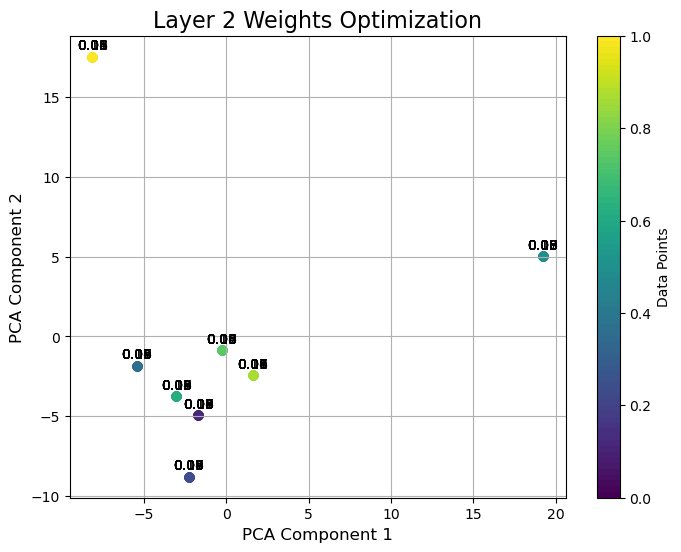

/local_scratch/slurm.692275/ipykernel_289204/2191941328.py:28: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(cm.ScalarMappable(cmap=colormap), label='Data Points')


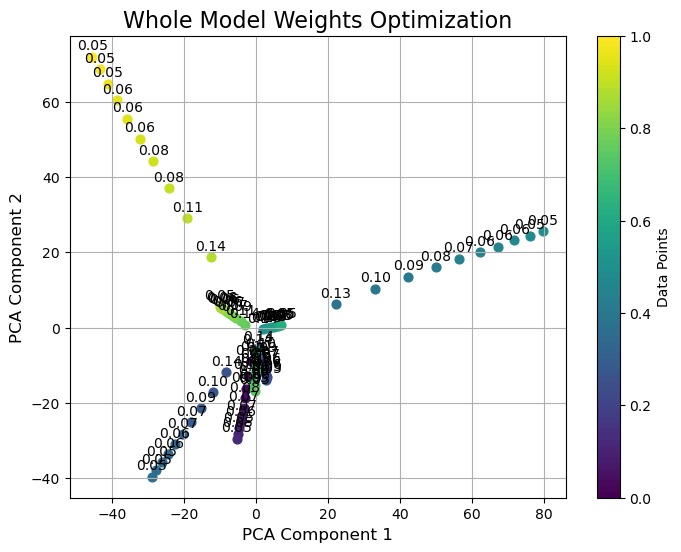

In [48]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm


colormap = cm.get_cmap('viridis', len(loss_flattened))

# Plot Layer 2 Optimization with multiple colors and smaller dot sizes
plt.figure(figsize=(8, 6))
for i, (x, y) in enumerate(layer2_reduced):  
    plt.scatter(x, y, c=[colormap(i)], marker='o', s=40)  
    plt.annotate(f"{loss_flattened[i]:.2f}", (x, y), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=10)
plt.title("Layer 2 Weights Optimization", fontsize=16)
plt.xlabel('PCA Component 1', fontsize=12)
plt.ylabel('PCA Component 2', fontsize=12)
plt.colorbar(cm.ScalarMappable(cmap=colormap), label='Data Points')
plt.grid(True)
plt.show()

# Plot Whole Model Optimization with multiple colors and smaller dot sizes
plt.figure(figsize=(8, 6))
for i, (x, y) in enumerate(whole_mod_reduced):
    plt.scatter(x, y, c=[colormap(i)], marker='o', s=40)  
    plt.annotate(f"{loss_flattened[i]:.2f}", (x, y), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=10)
plt.title("Whole Model Weights Optimization", fontsize=16)
plt.xlabel('PCA Component 1', fontsize=12)
plt.ylabel('PCA Component 2', fontsize=12)
plt.colorbar(cm.ScalarMappable(cmap=colormap), label='Data Points')
plt.grid(True)
plt.show()
